In [1]:
import warnings
from anndata import ImplicitModificationWarning
warnings.filterwarnings("ignore", category=ImplicitModificationWarning)
warnings.filterwarnings("ignore")

In [2]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import numpy as np
import scanpy as sc
import vqtcr as vq

In [3]:
path_base = '/mnt/d/Dataset/vqTCR/10xGenomics/'
path_data = path_base + 'avidity_esm.h5ad'

In [4]:
vq.set_random_seed(2025)
adata = sc.read_h5ad(path_data)
adata = adata[adata.obs['binding_name'].isin(vq.HIGH_COUNT_ANTIGENS)]
adata

View of AnnData object with n_obs × n_vars = 61096 × 5000
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'barcode',

In [5]:
params = vq.get_pred_config(lr=1e-4, latent_dim=64, dropout=0.2)
params['epoch'] = 20
params

{'dim_latent': 64,
 'batch_size': 512,
 'lr': 0.0001,
 'dropout': 0.2,
 'epoch': 20,
 'early': 10,
 'dataset': '',
 'save_path': '',
 'direction': 'max',
 'weight_decay': 0.0001,
 'loss_weight': [1.0, 1.0, 1.0, 1.0],
 'gex': {'dim_latent': 64, 'act': 'elu', 'norm': True},
 'tcr': {'esm_type': 'facebook/esm2_t6_8M_UR50D',
  'kmer_kernels': [1, 3, 5, 7],
  'dim_latent': 64,
  'dim_emb': 64,
  'num_heads': 8,
  'forward_expansion': 4,
  'dropout': 0.2,
  'num_encoder': 2,
  'num_decoder': 2,
  'mask_rate': 0.15,
  'beta_only': False,
  'esm_tokens': True},
 'fus': {'dim_latent': 64, 'dropout': 0.2, 'film_reg': 1.0},
 'pty': {'dim_latent': 128,
  'num_subspace': 3,
  'codewords_per_space': 64,
  'eps': 1e-05,
  'init_scale': 1.0,
  'ema_decay': 0.99,
  'commitment_beta': 0.25,
  'use_cosine': True,
  'dead_code_interval': 1000,
  'dead_code_threshold': 0.0001,
  'dead_code_topk': 16,
  'diversity_weight': 0.001},
 'pred': {'dim_latent': 64, 'dropout': 0.2, 'n_labels': 8}}

Leave one donor out(LoDonor) TCR-pMHC binding prediction

pretrain on all donors

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


warmup codebook:   0%|          | 0/20 [00:00<?, ?it/s]

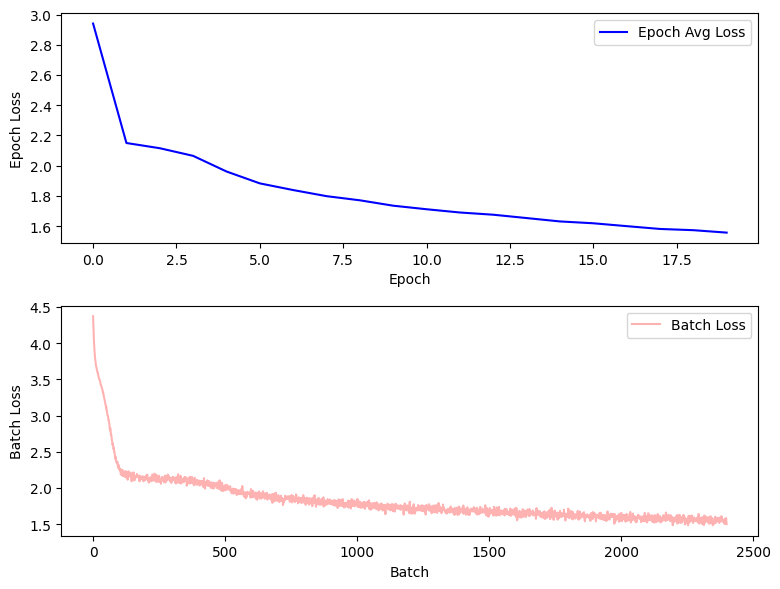

In [6]:
vqtcr = vq.vqTCR_Bench(params, adata, labels='binding_name', model='Concat')
vqtcr.pretrain(col_name='donor', 
               set_name=['donor_1', 'donor_2', 'donor_3', 'donor_4'],
               sample_mode='clonotype', 
               shuffle=False,
               labels=None,
               visual=True)

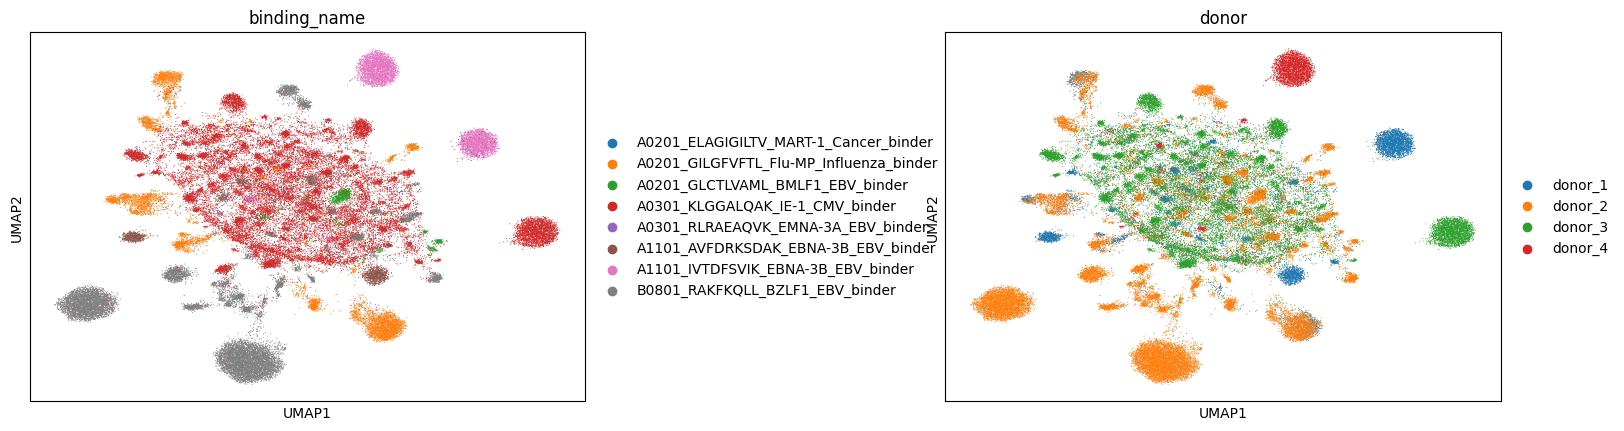

In [7]:
adata = vqtcr.get_latent(adata, col_name='donor', set_name=['donor_1', 'donor_2', 'donor_3', 'donor_4'])
# tcr latent space
sc.pp.neighbors(adata, use_rep='htcell')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['binding_name', 'donor'], wspace=0.5)

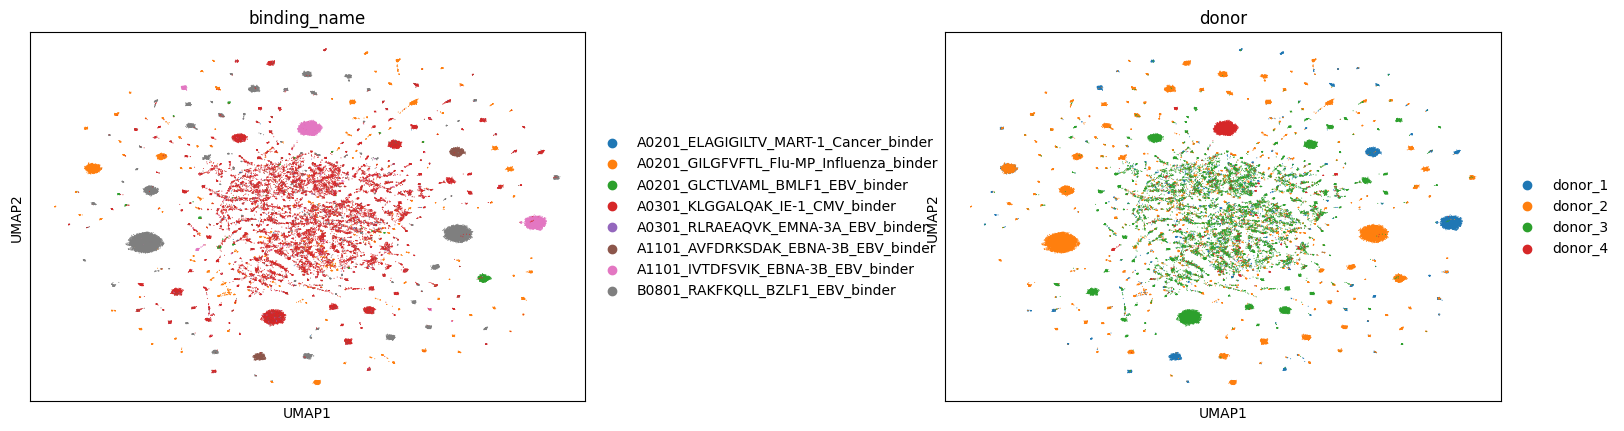

In [8]:
# tcr latent space
sc.pp.neighbors(adata, use_rep='htcr')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['binding_name', 'donor'], wspace=0.5)

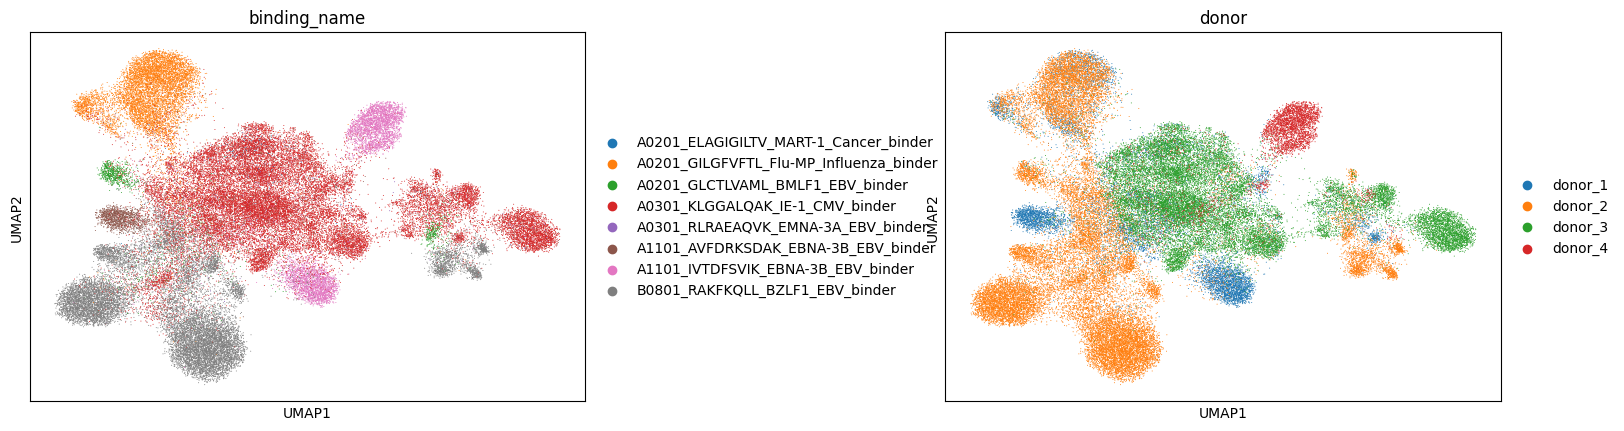

In [9]:
# gex residual latent space
sc.pp.neighbors(adata, use_rep='hgex')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['binding_name', 'donor'], wspace=0.5)

prediction training on remianing patients and test on leave-out patient

In [10]:
# test_score = vqtcr.compute_metrics(metrics='knn_prediction', eval_set='test')
record = {}
adata = vqtcr.get_latent(adata,col_name='donor', set_name=['donor_1', 'donor_2', 'donor_3', 'donor_4'])
adata_train = adata[adata.obs['set'].isin(['train', 'valid'])]
adata_valid = adata[adata.obs['set']=='test']

knn_scores = vq.get_knn_cls(adata_train.obsm['htcr'], adata_valid.obsm['htcr'],
                            adata_train.obs['binding_name'], 
                            adata_valid.obs['binding_name'])
record['knn_prediction'] = knn_scores['weighted avg']['f1-score']
record['knn_prediction']

0.4641393304138017

In [11]:
adata = vq.split_adata(adata, split_col='clonotype', random_seed=2025)
record = {}
adata = vqtcr.get_latent(adata, col_name='donor', set_name=['donor_1', 'donor_2', 'donor_3', 'donor_4'])
adata_train = adata[adata.obs['set']=='train']
adata_valid = adata[adata.obs['set']=='test']

knn_scores = vq.get_knn_cls(adata_train.obsm['htcr'], adata_valid.obsm['htcr'],
                            adata_train.obs['binding_name'], 
                            adata_valid.obs['binding_name'])
record['knn_prediction'] = knn_scores['weighted avg']['f1-score']
record['knn_prediction']

0.7835020299078728

In [12]:
from sklearn.model_selection import LeaveOneGroupOut, LeavePGroupsOut
logo = LeaveOneGroupOut()
all_test_metrics = []
donor_ids = adata.obs.donor.to_numpy()
import numpy as np
for train_valid_idx, test_idx in logo.split(X=adata.X, groups=donor_ids):
    test_donor = donor_ids[test_idx][0]
    print(f"\n=== test on {test_donor} ===")
    adata.obs.loc[adata.obs.index[train_valid_idx], 'set']='train'
    adata.obs.loc[adata.obs.index[test_idx], 'set'] = 'test'
    record = {}
    adata = vqtcr.get_latent(adata, col_name='donor', set_name=['donor_1', 'donor_2', 'donor_3', 'donor_4'])
    adata_train = adata[adata.obs['set']=='train']
    adata_valid = adata[adata.obs['set']=='test']

    knn_scores = vq.get_knn_cls(adata_train.obsm['htcr'], adata_valid.obsm['htcr'],
                                adata_train.obs['binding_name'], 
                                adata_valid.obs['binding_name'])
    record['knn_prediction'] = knn_scores['weighted avg']['f1-score']
    print(record['knn_prediction'])


=== test on donor_1 ===
0.8233662981386717

=== test on donor_2 ===
0.442315733453007

=== test on donor_3 ===
0.8142276523067593

=== test on donor_4 ===
0.07787585445679505


In [13]:
all_test_metrics = []
for train_valid_idx, test_idx in logo.split(X=adata.X, groups=donor_ids):
    test_donor = donor_ids[test_idx][0]
    print(f"\n=== test on {test_donor} ===")
    # split train-valid dataset
    adata_train_val = adata[train_valid_idx]
    train, val = vq.split_dataset(adata_train_val, split_ratio=0.25, 
                                  split_col='clonotype', random_seed=2025)
    adata.obs['set'] = None
    adata.obs.loc[train.obs.index, 'set'] = 'train'
    adata.obs.loc[val.obs.index, 'set'] = 'valid'
    adata.obs.loc[adata.obs.index[test_idx], 'set'] = 'test'
    trainloader = vq.get_dataloader(adata=adata, 
                                     batch_size=params['batch_size'],
                                     col_name='set',
                                     set_name=['train'],
                                     sample_mode='clonotype',
                                     shuffle=False, 
                                     labels='binding_name')
    validloader = vq.get_dataloader(adata=adata, 
                                     batch_size=params['batch_size'],
                                     col_name='set',
                                     set_name=['valid'],
                                     sample_mode=None,
                                     shuffle=False, 
                                     labels='binding_name')
    testloader = vq.get_dataloader(adata=adata, 
                                     batch_size=params['batch_size'],
                                     col_name='set',
                                     set_name=['test'],
                                     sample_mode=None,
                                     shuffle=False, 
                                     labels='binding_name')
    best_score = vqtcr.predict_train(trainloader, validloader)
    print(f'best score in validation: {best_score}')
    
    test_metrics = vqtcr.predict_test(testloader)
    all_test_metrics.append(test_metrics)
    
metric = 'weighted'
print("\n" + "="*60)
print("LOGO交叉验证最终结果:")
for i, metrics in enumerate(all_test_metrics):
        print(f"病人 {np.unique(donor_ids)[i]}: "
              f"f1: {metrics[f'f1_{metric}']:.3f}, "
              f"AUC-ROC: {metrics[f'auc_roc_{metric}']:.3f}, "
              f"AUC-PR: {metrics[f'auc_pr_{metric}']:.3f}")
    
# 计算平均性能
mean_f1 = np.nanmean([m[f'f1_{metric}'] for m in all_test_metrics])
mean_auc_roc = np.nanmean([m[f'auc_roc_{metric}'] for m in all_test_metrics])
mean_auc_pr = np.nanmean([m[f'auc_pr_{metric}'] for m in all_test_metrics])

print(f"\n平均性能: "
        f"fa: {mean_f1:.3f} ± {np.nanstd([m[f'f1_{metric}'] for m in all_test_metrics]):.3f}, "
        f"AUC-ROC: {mean_auc_roc:.3f} ± {np.nanstd([m[f'auc_roc_{metric}'] for m in all_test_metrics]):.3f}, "
        f"AUC-PR: {mean_auc_pr:.3f} ± {np.nanstd([m[f'auc_pr_{metric}'] for m in all_test_metrics]):.3f}")


=== test on donor_1 ===


Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.552
Val F1: 0.782, Val AUC-ROC: 0.937, Val AUC-PR: 0.359
Epoch 2/20:
  Train Loss: 0.995
Val F1: 0.853, Val AUC-ROC: 0.961, Val AUC-PR: 0.403
Epoch 3/20:
  Train Loss: 0.892
Val F1: 0.877, Val AUC-ROC: 0.967, Val AUC-PR: 0.417
Epoch 4/20:
  Train Loss: 0.698
Val F1: 0.885, Val AUC-ROC: 0.970, Val AUC-PR: 0.434
Epoch 5/20:
  Train Loss: 0.701
Val F1: 0.886, Val AUC-ROC: 0.972, Val AUC-PR: 0.446
Epoch 6/20:
  Train Loss: 0.718
Val F1: 0.889, Val AUC-ROC: 0.973, Val AUC-PR: 0.456
Epoch 7/20:
  Train Loss: 0.577
Val F1: 0.886, Val AUC-ROC: 0.974, Val AUC-PR: 0.460
Epoch 8/20:
  Train Loss: 0.548
Val F1: 0.889, Val AUC-ROC: 0.975, Val AUC-PR: 0.454
Epoch 9/20:
  Train Loss: 0.552
Val F1: 0.890, Val AUC-ROC: 0.976, Val AUC-PR: 0.464
Epoch 10/20:
  Train Loss: 0.522
Val F1: 0.890, Val AUC-ROC: 0.976, Val AUC-PR: 0.460
Epoch 11/20:
  Train Loss: 0.501
Val F1: 0.894, Val AUC-ROC: 0.977, Val AUC-PR: 0.467
Epoch 12/20:
  Train Loss: 0.717
Val F1: 0.892, Val AUC-ROC: 0.

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.813
Val F1: 0.648, Val AUC-ROC: 0.882, Val AUC-PR: 0.365
Epoch 2/20:
  Train Loss: 1.538
Val F1: 0.728, Val AUC-ROC: 0.897, Val AUC-PR: 0.392
Epoch 3/20:
  Train Loss: 1.295
Val F1: 0.628, Val AUC-ROC: 0.898, Val AUC-PR: 0.413
Epoch 4/20:
  Train Loss: 1.063
Val F1: 0.450, Val AUC-ROC: 0.897, Val AUC-PR: 0.415
Epoch 5/20:
  Train Loss: 0.959
Val F1: 0.403, Val AUC-ROC: 0.905, Val AUC-PR: 0.432
Epoch 6/20:
  Train Loss: 0.795
Val F1: 0.387, Val AUC-ROC: 0.901, Val AUC-PR: 0.441
Epoch 7/20:
  Train Loss: 0.759
Val F1: 0.391, Val AUC-ROC: 0.918, Val AUC-PR: 0.454
Epoch 8/20:
  Train Loss: 0.659
Val F1: 0.390, Val AUC-ROC: 0.923, Val AUC-PR: 0.468
Epoch 9/20:
  Train Loss: 0.613
Val F1: 0.389, Val AUC-ROC: 0.924, Val AUC-PR: 0.467
Epoch 10/20:
  Train Loss: 0.724
Val F1: 0.410, Val AUC-ROC: 0.930, Val AUC-PR: 0.474
Epoch 11/20:
  Train Loss: 0.551
Val F1: 0.392, Val AUC-ROC: 0.931, Val AUC-PR: 0.475
Epoch 12/20:
  Train Loss: 0.512
Val F1: 0.465, Val AUC-ROC: 0.

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.441
Val F1: 0.566, Val AUC-ROC: 0.887, Val AUC-PR: 0.345
Epoch 2/20:
  Train Loss: 1.278
Val F1: 0.594, Val AUC-ROC: 0.919, Val AUC-PR: 0.384
Epoch 3/20:
  Train Loss: 1.220
Val F1: 0.605, Val AUC-ROC: 0.938, Val AUC-PR: 0.433
Epoch 4/20:
  Train Loss: 1.058
Val F1: 0.628, Val AUC-ROC: 0.948, Val AUC-PR: 0.458
Epoch 5/20:
  Train Loss: 0.962
Val F1: 0.673, Val AUC-ROC: 0.953, Val AUC-PR: 0.485
Epoch 6/20:
  Train Loss: 1.007
Val F1: 0.716, Val AUC-ROC: 0.957, Val AUC-PR: 0.501
Epoch 7/20:
  Train Loss: 1.014
Val F1: 0.749, Val AUC-ROC: 0.959, Val AUC-PR: 0.523
Epoch 8/20:
  Train Loss: 0.937
Val F1: 0.781, Val AUC-ROC: 0.962, Val AUC-PR: 0.536
Epoch 9/20:
  Train Loss: 0.853
Val F1: 0.795, Val AUC-ROC: 0.964, Val AUC-PR: 0.540
Epoch 10/20:
  Train Loss: 0.867
Val F1: 0.812, Val AUC-ROC: 0.967, Val AUC-PR: 0.542
Epoch 11/20:
  Train Loss: 0.933
Val F1: 0.816, Val AUC-ROC: 0.968, Val AUC-PR: 0.555
Epoch 12/20:
  Train Loss: 0.885
Val F1: 0.834, Val AUC-ROC: 0.

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.316
Val F1: 0.698, Val AUC-ROC: 0.923, Val AUC-PR: 0.354
Epoch 2/20:
  Train Loss: 1.183
Val F1: 0.792, Val AUC-ROC: 0.941, Val AUC-PR: 0.378
Epoch 3/20:
  Train Loss: 0.802
Val F1: 0.823, Val AUC-ROC: 0.950, Val AUC-PR: 0.405
Epoch 4/20:
  Train Loss: 0.786
Val F1: 0.825, Val AUC-ROC: 0.954, Val AUC-PR: 0.422
Epoch 5/20:
  Train Loss: 0.307
Val F1: 0.827, Val AUC-ROC: 0.957, Val AUC-PR: 0.427
Epoch 6/20:
  Train Loss: 0.164
Val F1: 0.824, Val AUC-ROC: 0.958, Val AUC-PR: 0.444
Epoch 7/20:
  Train Loss: 0.213
Val F1: 0.828, Val AUC-ROC: 0.961, Val AUC-PR: 0.450
Epoch 8/20:
  Train Loss: 0.236
Val F1: 0.835, Val AUC-ROC: 0.963, Val AUC-PR: 0.468
Epoch 9/20:
  Train Loss: 1.649
Val F1: 0.828, Val AUC-ROC: 0.962, Val AUC-PR: 0.471
Epoch 10/20:
  Train Loss: 0.121
Val F1: 0.828, Val AUC-ROC: 0.964, Val AUC-PR: 0.477
Epoch 11/20:
  Train Loss: 2.645
Val F1: 0.825, Val AUC-ROC: 0.963, Val AUC-PR: 0.463
Epoch 12/20:
  Train Loss: 3.006
Val F1: 0.831, Val AUC-ROC: 0.

In [14]:
all_test_metrics = []
for i in range(5):
    adata = vq.split_adata(adata, split_col='clonotype', random_seed=i)
    trainloader = vq.get_dataloader(adata=adata, 
                                     batch_size=params['batch_size'],
                                     col_name='set',
                                     set_name=['train'],
                                     sample_mode='clonotype',
                                     shuffle=False, 
                                     labels='binding_name')
    validloader = vq.get_dataloader(adata=adata, 
                                     batch_size=params['batch_size'],
                                     col_name='set',
                                     set_name=['valid'],
                                     sample_mode=None,
                                     shuffle=False, 
                                     labels='binding_name')
    testloader = vq.get_dataloader(adata=adata,
                                     batch_size=params['batch_size'],
                                     col_name='set',
                                     set_name=['test'],
                                     sample_mode=None,
                                     shuffle=False,
                                     labels='binding_name')
    best_score = vqtcr.predict_train(trainloader, validloader)
    print(f'best score in validation: {best_score}')
    
    test_metrics = vqtcr.predict_test(testloader)
    all_test_metrics.append(test_metrics)

print("\n" + "="*60)
print("LOGO交叉验证最终结果:")
for i, metrics in enumerate(all_test_metrics):
        print(f"splite {i}: "
              f"F1: {metrics[f'f1_{metric}']:.3f}, "
              f"AUC-ROC: {metrics[f'auc_roc_{metric}']:.3f}, "
              f"AUC-PR: {metrics[f'auc_pr_{metric}']:.3f}")
    
# 计算平均性能
mean_f1 = np.nanmean([m[f'f1_{metric}'] for m in all_test_metrics])
mean_auc_roc = np.nanmean([m[f'auc_roc_{metric}'] for m in all_test_metrics])
mean_auc_pr = np.nanmean([m[f'auc_pr_{metric}'] for m in all_test_metrics])

print(f"\n平均性能: "
        f"F1: {mean_f1:.3f} ± {np.nanstd([m[f'f1_{metric}'] for m in all_test_metrics]):.3f}, "
        f"AUC-ROC: {mean_auc_roc:.3f} ± {np.nanstd([m[f'auc_roc_{metric}'] for m in all_test_metrics]):.3f}, "
        f"AUC-PR: {mean_auc_pr:.3f} ± {np.nanstd([m[f'auc_pr_{metric}'] for m in all_test_metrics]):.3f}")

    

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.520
Val F1: 0.699, Val AUC-ROC: 0.848, Val AUC-PR: 0.326
Epoch 2/20:
  Train Loss: 1.210
Val F1: 0.743, Val AUC-ROC: 0.875, Val AUC-PR: 0.364
Epoch 3/20:
  Train Loss: 0.979
Val F1: 0.762, Val AUC-ROC: 0.883, Val AUC-PR: 0.376
Epoch 4/20:
  Train Loss: 0.818
Val F1: 0.775, Val AUC-ROC: 0.894, Val AUC-PR: 0.388
Epoch 5/20:
  Train Loss: 0.696
Val F1: 0.777, Val AUC-ROC: 0.898, Val AUC-PR: 0.394
Epoch 6/20:
  Train Loss: 0.687
Val F1: 0.778, Val AUC-ROC: 0.902, Val AUC-PR: 0.401
Epoch 7/20:
  Train Loss: 0.685
Val F1: 0.776, Val AUC-ROC: 0.905, Val AUC-PR: 0.407
Epoch 8/20:
  Train Loss: 0.663
Val F1: 0.778, Val AUC-ROC: 0.908, Val AUC-PR: 0.413
Epoch 9/20:
  Train Loss: 0.651
Val F1: 0.778, Val AUC-ROC: 0.905, Val AUC-PR: 0.414
Epoch 10/20:
  Train Loss: 0.649
Val F1: 0.779, Val AUC-ROC: 0.908, Val AUC-PR: 0.419
Epoch 11/20:
  Train Loss: 0.551
Val F1: 0.780, Val AUC-ROC: 0.907, Val AUC-PR: 0.423
Epoch 12/20:
  Train Loss: 0.715
Val F1: 0.779, Val AUC-ROC: 0.

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.542
Val F1: 0.589, Val AUC-ROC: 0.759, Val AUC-PR: 0.325
Epoch 2/20:
  Train Loss: 1.097
Val F1: 0.638, Val AUC-ROC: 0.823, Val AUC-PR: 0.359
Epoch 3/20:
  Train Loss: 0.941
Val F1: 0.667, Val AUC-ROC: 0.853, Val AUC-PR: 0.383
Epoch 4/20:
  Train Loss: 0.851
Val F1: 0.677, Val AUC-ROC: 0.872, Val AUC-PR: 0.400
Epoch 5/20:
  Train Loss: 0.706
Val F1: 0.679, Val AUC-ROC: 0.876, Val AUC-PR: 0.402
Epoch 6/20:
  Train Loss: 0.642
Val F1: 0.677, Val AUC-ROC: 0.878, Val AUC-PR: 0.401
Epoch 7/20:
  Train Loss: 0.674
Val F1: 0.676, Val AUC-ROC: 0.882, Val AUC-PR: 0.402
Epoch 8/20:
  Train Loss: 0.564
Val F1: 0.678, Val AUC-ROC: 0.886, Val AUC-PR: 0.407
Epoch 9/20:
  Train Loss: 0.623
Val F1: 0.678, Val AUC-ROC: 0.887, Val AUC-PR: 0.412
Epoch 10/20:
  Train Loss: 0.727
Val F1: 0.677, Val AUC-ROC: 0.887, Val AUC-PR: 0.413
Epoch 11/20:
  Train Loss: 0.674
Val F1: 0.680, Val AUC-ROC: 0.889, Val AUC-PR: 0.416
Epoch 12/20:
  Train Loss: 0.507
Val F1: 0.682, Val AUC-ROC: 0.

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.598
Val F1: 0.768, Val AUC-ROC: 0.908, Val AUC-PR: 0.346
Epoch 2/20:
  Train Loss: 1.255
Val F1: 0.841, Val AUC-ROC: 0.960, Val AUC-PR: 0.371
Epoch 3/20:
  Train Loss: 1.086
Val F1: 0.864, Val AUC-ROC: 0.967, Val AUC-PR: 0.385
Epoch 4/20:
  Train Loss: 0.890
Val F1: 0.874, Val AUC-ROC: 0.971, Val AUC-PR: 0.395
Epoch 5/20:
  Train Loss: 0.823
Val F1: 0.874, Val AUC-ROC: 0.972, Val AUC-PR: 0.403
Epoch 6/20:
  Train Loss: 0.732
Val F1: 0.877, Val AUC-ROC: 0.974, Val AUC-PR: 0.407
Epoch 7/20:
  Train Loss: 0.753
Val F1: 0.877, Val AUC-ROC: 0.975, Val AUC-PR: 0.414
Epoch 8/20:
  Train Loss: 0.665
Val F1: 0.878, Val AUC-ROC: 0.976, Val AUC-PR: 0.416
Epoch 9/20:
  Train Loss: 0.676
Val F1: 0.876, Val AUC-ROC: 0.975, Val AUC-PR: 0.423
Epoch 10/20:
  Train Loss: 0.572
Val F1: 0.880, Val AUC-ROC: 0.977, Val AUC-PR: 0.430
Epoch 11/20:
  Train Loss: 0.642
Val F1: 0.879, Val AUC-ROC: 0.976, Val AUC-PR: 0.436
Epoch 12/20:
  Train Loss: 0.618
Val F1: 0.880, Val AUC-ROC: 0.

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.509
Val F1: 0.712, Val AUC-ROC: 0.927, Val AUC-PR: 0.357
Epoch 2/20:
  Train Loss: 1.139
Val F1: 0.802, Val AUC-ROC: 0.947, Val AUC-PR: 0.385
Epoch 3/20:
  Train Loss: 0.968
Val F1: 0.826, Val AUC-ROC: 0.955, Val AUC-PR: 0.407
Epoch 4/20:
  Train Loss: 0.813
Val F1: 0.824, Val AUC-ROC: 0.958, Val AUC-PR: 0.426
Epoch 5/20:
  Train Loss: 0.777
Val F1: 0.823, Val AUC-ROC: 0.961, Val AUC-PR: 0.436
Epoch 6/20:
  Train Loss: 0.611
Val F1: 0.816, Val AUC-ROC: 0.963, Val AUC-PR: 0.453
Epoch 7/20:
  Train Loss: 0.605
Val F1: 0.819, Val AUC-ROC: 0.965, Val AUC-PR: 0.457
Epoch 8/20:
  Train Loss: 0.576
Val F1: 0.819, Val AUC-ROC: 0.966, Val AUC-PR: 0.470
Epoch 9/20:
  Train Loss: 0.648
Val F1: 0.820, Val AUC-ROC: 0.967, Val AUC-PR: 0.480
Epoch 10/20:
  Train Loss: 0.628
Val F1: 0.827, Val AUC-ROC: 0.968, Val AUC-PR: 0.475
Epoch 11/20:
  Train Loss: 0.653
Val F1: 0.829, Val AUC-ROC: 0.967, Val AUC-PR: 0.485
Epoch 12/20:
  Train Loss: 0.639
Val F1: 0.833, Val AUC-ROC: 0.

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.563
Val F1: 0.736, Val AUC-ROC: 0.944, Val AUC-PR: 0.376
Epoch 2/20:
  Train Loss: 1.221
Val F1: 0.776, Val AUC-ROC: 0.957, Val AUC-PR: 0.396
Epoch 3/20:
  Train Loss: 1.047
Val F1: 0.793, Val AUC-ROC: 0.961, Val AUC-PR: 0.409
Epoch 4/20:
  Train Loss: 0.815
Val F1: 0.804, Val AUC-ROC: 0.965, Val AUC-PR: 0.424
Epoch 5/20:
  Train Loss: 0.763
Val F1: 0.807, Val AUC-ROC: 0.966, Val AUC-PR: 0.435
Epoch 6/20:
  Train Loss: 0.667
Val F1: 0.808, Val AUC-ROC: 0.967, Val AUC-PR: 0.442
Epoch 7/20:
  Train Loss: 0.749
Val F1: 0.809, Val AUC-ROC: 0.967, Val AUC-PR: 0.445
Epoch 8/20:
  Train Loss: 0.684
Val F1: 0.807, Val AUC-ROC: 0.966, Val AUC-PR: 0.446
Epoch 9/20:
  Train Loss: 0.593
Val F1: 0.808, Val AUC-ROC: 0.968, Val AUC-PR: 0.457
Epoch 10/20:
  Train Loss: 0.614
Val F1: 0.808, Val AUC-ROC: 0.968, Val AUC-PR: 0.456
Epoch 11/20:
  Train Loss: 0.554
Val F1: 0.808, Val AUC-ROC: 0.967, Val AUC-PR: 0.456
Epoch 12/20:
  Train Loss: 0.552
Val F1: 0.810, Val AUC-ROC: 0.